# Implementação

## Importação das bibliotecas



O módulo `vision` contem os recursos para implementação de modelos de classificação de imagens:


In [1]:
from fastai.vision.all import *

In [20]:
import warnings
warnings.filterwarnings('ignore')

## Importação da base de dados


O *dataset* utilizado está disponível no site Kaggle. Para facilitar a utilização, fiz o upload dos arquivos para o repositório do projeto no Github.
O código abaixo cria a pasta `assets` para receber o *download* dos arquivos:


In [ ]:
! mkdir assets
! wget -O ./assets/dataset.zip https://github.com/kamillafsilva/cv-coral-classification/blob/main/archive.zip?raw=true
! unzip './assets/dataset.zip' -d './assets/dataset'

Ao descompactar o arquivo `dataset.zip` a pasta `dataset` fica com a seguinte estrutura:

```
ROOT: Bleached Corals and Healthy Corals Classification
| -- train: Training
| ---- class_1: bleached_corals (corais branqueados)
| ---- class_2: healthy_corals (corais saudáveis)
| -- valid: Validation
| ---- class_1: bleached_corals (corais branqueados)
| ---- class_2: healthy_corals (corais saudáveis)
```

Essa estrutura falicilita a leitura dos dados, pois, o método `from_folder` consegue identificar as pastas com os conjuntos de teste e de validação, além de detectar as classes das imagens pelo nome das subpastas (`bleached_corals` e `healthy_corals`)

In [3]:
path = './assets/dataset/Bleached Corals and Healthy Corals Classification/'
dls = ImageDataLoaders.from_folder(path, train ='Training', valid = 'Validation', item_tfms=Resize(224))

Podemos verificar algumas das imagens carregadas com o método `show_batch`:

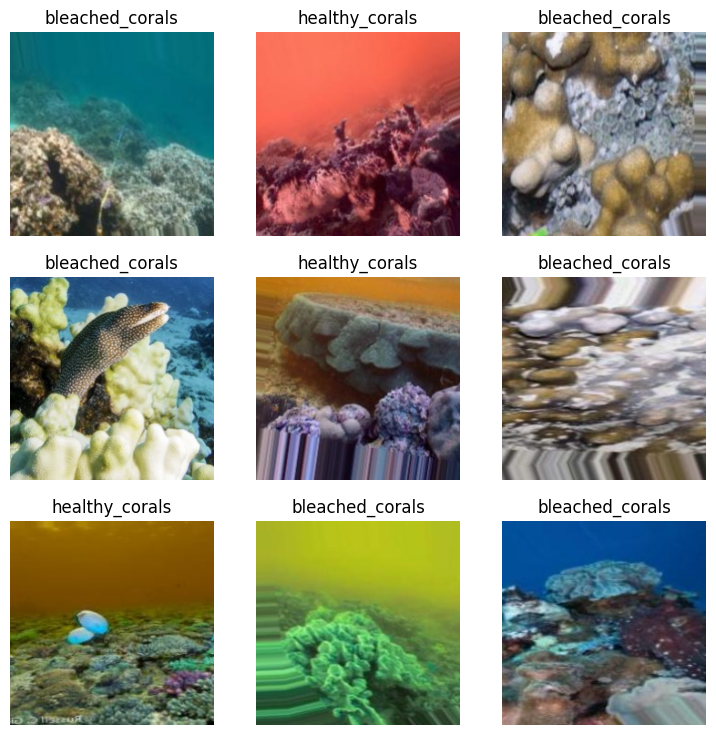

In [4]:
dls.show_batch()

## Treinando o modelo




Para classificação dos corais podemos utilizar um modelo pré treinado do pacote `fastai` e adapta-lo ao problema em questão, essa técnica é chamada de aprendizado por transferência. Abaixo utilizamos o modelo [ResNet34](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) para essa tarefa:

In [37]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.766461,0.532190,0.764467,00:32


epoch,train_loss,valid_loss,accuracy,time
0,0.470543,0.297249,0.871066,00:40
1,0.226349,0.155130,0.942132,00:41
2,0.094672,0.135168,0.948223,00:40


Treinando o modelo por 3 epochs conseguimos atingir 94,8% de acurácia no conjunto de validação. Podemos melhorar esse resultado utizando o valor ótimo para o parâmetro *learning rate* com o método `lr_find`:

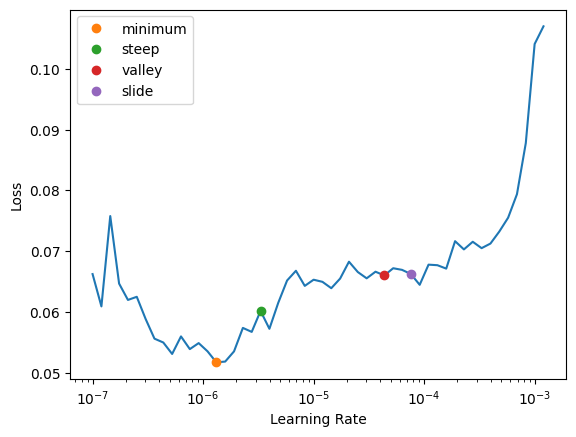

In [39]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [40]:
learn.fine_tune(3, lrs.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.067438,0.129120,0.951269,00:34


epoch,train_loss,valid_loss,accuracy,time
0,0.061362,0.129277,0.952284,00:40
1,0.054802,0.120846,0.953299,00:40
2,0.053843,0.121570,0.954315,00:40


Utilizando o valor ótimo para o *learning rate* alcançamos 95,4% de acurácia.

## Análisando os resultados




A matriz de confusão abaixo compara as classes observadas com as classes preditas pelo modelo. O modelo classificou corretamente 95% dos corais branqueados e 96% dos corais saudáveis.

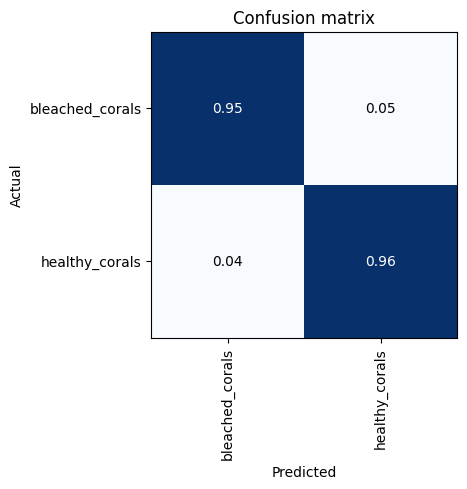

In [41]:
clf_interp = ClassificationInterpretation.from_learner(learn)
clf_interp.plot_confusion_matrix(normalize = True)

Também podemos verificar os casos em que os modelos fez os piores erros com o método `plot_top_losses`. Por exemplo, para a primeira imagem, o modelo classificou o coral como saúdavel com 99% de pobabilidade. No entanto, esse era um coral branqueado. Analisando esses casos os pesquisadores podem entender quais características das imagens coletadas causam confusão no modelo ou identificar marcações incorretas.

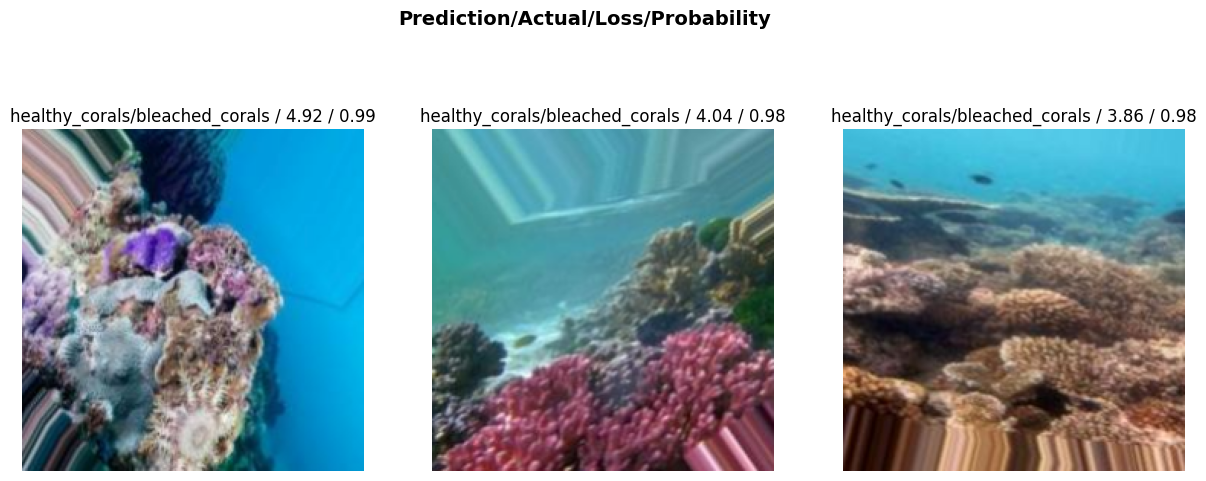

In [42]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(3, figsize=(15, 6))

Por fim, o modelo treinado pode ser exportado para um arquivo com o método `export`:

In [45]:
learn.export('coral_learn.pkl')